Load the data

In [22]:
from preprocessing import load_folder_paths, load_dcm_datasets, get_volume
from scipy import ndimage
import matplotlib.pyplot as plt

paths = load_folder_paths()

v = get_volume(paths[13], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)
v1 = v[0]
v2 = v[1]
v_smoothed = ndimage.gaussian_filter(v1, sigma=1.0)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Total time taken: 11.76 seconds
Average time taken per volume: 5.88 seconds
Done!


In [23]:
import numpy as np
import SimpleITK as sitk

Interactive Visualization Functions

In [63]:
from ipywidgets import interact, IntSlider

def overlay_volume_sequence_interactive(volume_seq):
    num_overlays = len(volume_seq) - 1
    nrows = max(1, int(num_overlays ** 0.5))
    ncols = (num_overlays + nrows - 1) // nrows
    print(f"{nrows=} {ncols=}")
    def plot_slice(slice_idx):

        fig, axes = plt.subplots(nrows, 
                                ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
        print(f"{axes=}")
        for i in range(num_overlays):
            ax = axes[i // ncols][i % ncols]
            print(f"{ax=}")
            ax.imshow(volume_seq[0][slice_idx], cmap="gray")
            ax.imshow(volume_seq[i+1][slice_idx], cmap="hot", alpha=0.5)
        plt.show(block=True)
    
    interact(
        plot_slice,
        slice_idx=IntSlider(
            min=0,
            max=len(volume_seq[0])-1, 
            step=1,
            value=0,
            description='Slice:'
        )
    )

def multi_vol_seq_interactive(volume_seqs, titles=None):
    """
    Interactive plot of multiple volume sequences using ipywidgets
    
    Parameters:
    - volume_seqs: List of 4D volume sequences to display
    - titles: Optional list of titles for each sequence
    """
    if titles is None:
        titles = [f"Volume {i+1}" for i in range(len(volume_seqs))]
        
    num_volumes = len(volume_seqs)
    nrows = int(num_volumes ** 0.5)
    ncols = (num_volumes + nrows - 1) // nrows
    
    def plot_volumes(time_idx, slice_idx):
        fig, axes = plt.subplots(nrows, ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
                
        for i, (volume_seq, title) in enumerate(zip(volume_seqs, titles)):
            row, col = i // ncols, i % ncols
            ax = axes[row][col]
            
            t = min(time_idx, len(volume_seq) - 1)
            s = min(slice_idx, len(volume_seq[t]) - 1)
            
            im = ax.imshow(volume_seq[t][s], cmap='magma')
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
            
        plt.tight_layout()
        plt.show(block=True)
        
    max_time = max(len(vol) for vol in volume_seqs) - 1
    max_slice = max(len(vol[0]) for vol in volume_seqs) - 1
    
    interact(
        plot_volumes,
        time_idx=IntSlider(min=0, max=max_time, step=1, value=0, description='Time:'),
        slice_idx=IntSlider(min=0, max=max_slice, step=1, value=0, description='Slice:')
    )



In [25]:
overlay_volume_sequence_interactive(v)

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [26]:
multi_vol_seq_interactive([v, v])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

Intra-registration plotting functions 
(from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/61_Registration_Introduction_Continued.html)

In [74]:
from IPython.display import clear_output
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method, metric_name='Metric Value'):
    if registration_method.GetOptimizerIteration() % 10 == 0:
        global metric_values, multires_iterations

        metric_values.append(registration_method.GetMetricValue())
        # Clear the output area (wait=True, to reduce flickering), and plot current data
        clear_output(wait=True)
        # Plot the similarity metric values
        plt.plot(metric_values, "r")
        plt.plot(
            multires_iterations,
            [metric_values[index] for index in multires_iterations],
            "b*",
        )
        plt.xlabel("Iteration Number", fontsize=12)
        plt.ylabel(metric_name, fontsize=12)
        plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## First in-plane registration method
Experimented with:
- Different Metric scores (MSE and Mutual Information)
- Optimizers (Gradient Descent and Regular Step GD)
- Optimization Parameters (Learning Rates, Relaxation Factors, Convergence Monitoring Parameters)
- Multi-Resolution Framework settings

In [28]:
from time import time
from preprocessing import get_skull_mask
def register_volume_inplane_weighted(moving_volume: np.ndarray, reference_volume: np.ndarray, 
                      n_samples: int = 5, lr: float = 1.0, n_iters: int = 1000, multi_res: bool = False,
                      plot_metrics: bool = True
                      ) -> np.ndarray:
    """
    Performs in-plane registration by:
    1. Sampling n evenly-spaced slices
    2. Performing 2D registration on each slice
    3. Averaging transformations weighted by their metric values
    4. Applying final transformation to entire volume
    
    Args:
        moving_volume: Volume to be registered (Y, Z, X)
        reference_volume: Reference volume (Y, Z, X)
        n_samples: Number of slices to sample for registration
        lr: Learning rate for registration
        n_iters: Number of iterations for registration
        spacing: Physical spacing of the volume (Y, Z, X)
    """
    Y, Z, X = moving_volume.shape
    
    # Sample slice indices evenly from center
    center_idx = Y // 2
    if n_samples == 1:
        slice_indices = np.array([center_idx])
    else:
        half_range = (Y // 4)
        slice_indices = np.linspace(center_idx - half_range, center_idx + half_range, n_samples, dtype=int)
    
    # Store transforms and their weights
    transforms = []
    metric_values = []

    def adapt_learning_rate(method):
        # Every 10 iterations, decrease lr by 5%
        if method.GetOptimizerIteration() % 10 == 0:
            method.SetOptimizerLearningRate(method.GetOptimizerLearningRate() * 0.95)
            print(f"Learning rate decreased to {method.GetOptimizerLearningRate():.4f}")

        
    # Register each sampled slice
    for slice_idx in slice_indices:
        print(f"Registering slice {slice_idx} of {Y}")
        # Get corresponding slices
        moving_slice = moving_volume[slice_idx]
        reference_slice = reference_volume[slice_idx]
        
        # Convert to SimpleITK images
        moving_image = sitk.GetImageFromArray(ndimage.gaussian_filter(moving_slice, sigma=1.0))
        reference_image = sitk.GetImageFromArray(ndimage.gaussian_filter(reference_slice, sigma=1.0))
        
        # Set 2D spacing
        moving_image.SetSpacing((1, 1))
        reference_image.SetSpacing((1, 1))
        
        # Initialize 2D transform
        initial_transform = sitk.CenteredTransformInitializer(
            reference_image,
            moving_image,
            sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        # Setup registration method
        registration_method = sitk.ImageRegistrationMethod()
        # registration_method.SetMetricAsMeanSquares()
        # Similarity metric settings
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.1)

        
        # Interpolator settings
        registration_method.SetInterpolator(sitk.sitkLinear)

        # Optimizer settings
        # registration_method.SetOptimizerAsGradientDescent(
        #     learningRate=lr,
        #     estimateLearningRate=sitk.ImageRegistrationMethod.EachIteration,
        #     numberOfIterations=n_iters,
        #     convergenceMinimumValue=1e-6,            
        #     convergenceWindowSize=10,
        #     maximumStepSizeInPhysicalUnits=4

        # )
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=lr,
            minStep=1e-6,
            numberOfIterations=n_iters,
            gradientMagnitudeTolerance=1e-6,
            relaxationFactor=0.5,
            maximumStepSizeInPhysicalUnits=4
        )
        
        # Add convergence monitoring
        # registration_method.SetOptimizerScalesFromIndexShift()
        
        if multi_res:
            registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[2, 1])
            registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[0, 0])
            registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        
        registration_method.SetInitialTransform(initial_transform)
        if plot_metrics:
            registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
            registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
            registration_method.AddCommand(
                sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
            )
            registration_method.AddCommand(
                sitk.sitkIterationEvent, lambda: plot_values(registration_method)
            )
        # registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

        try:
            final_transform = registration_method.Execute(reference_image, moving_image)
            metric_value = registration_method.GetMetricValue()
            print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
            # Store transform parameters and weight
            params = final_transform.GetParameters()
            center = final_transform.GetCenter()
            transforms.append((params, center))
            metric_values.append(metric_value)
            
        except RuntimeError as e:
            print(f"Registration failed for slice {slice_idx}: {e}")
            continue
    
    if not transforms:
        print("No successful registrations - returning original volume")
        return moving_volume
    
    # Convert metric values to weights based on chosen scheme
    metric_values = np.array(metric_values)
    print(np.mean(metric_values))
    
    # The smaller the metric value, the more that transformation weighs into final transformation
    weights = 1 / (metric_values + 1e-10)
    
    # Normalize weights
    weights = weights / np.sum(weights)
    print(weights)
    # Compute weighted average transformation
    avg_angle = 0
    avg_tx = 0
    avg_ty = 0
    avg_cx = 0
    avg_cy = 0
    
    for (params, center), weight in zip(transforms, weights):
        avg_angle += params[0] * weight
        avg_tx += params[1] * weight
        avg_ty += params[2] * weight
        avg_cx += center[0] * weight
        avg_cy += center[1] * weight
    
    print(f"{avg_angle=:.4f} {avg_tx=:.4f} {avg_ty=:.4f} {avg_cx=:.4f} {avg_cy=:.4f}")

    # Create final average transform
    final_transform = sitk.Euler2DTransform()
    final_transform.SetAngle(avg_angle)
    final_transform.SetTranslation((avg_tx, avg_ty))
    final_transform.SetCenter((avg_cx, avg_cy))
    
    # Apply transform to each slice of moving volume
    registered_volume = np.zeros_like(moving_volume)
    for i in range(moving_volume.shape[0]):
        moving_slice = sitk.GetImageFromArray(moving_volume[i])
        registered_slice = sitk.Resample(
            moving_slice,
            reference_image,
            final_transform,
            sitk.sitkLinear,
            0.0,
            moving_slice.GetPixelID()
        )
        registered_volume[i] = sitk.GetArrayFromImage(registered_slice)

    return registered_volume

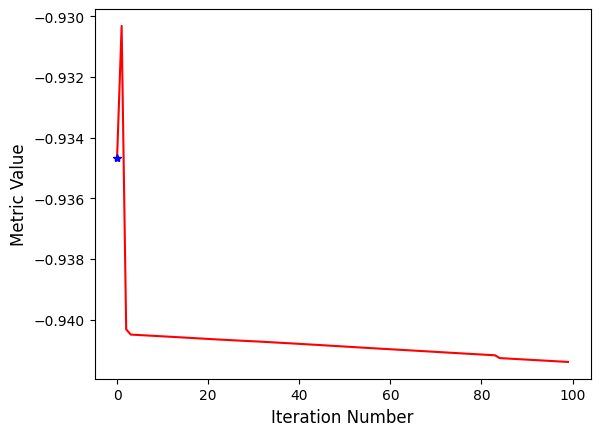

Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (1000) exceeded.
-0.9192427683932195
[0.38033    0.29756528 0.32210472]
avg_angle=0.0069 avg_tx=-0.2729 avg_ty=0.0305 avg_cx=127.5000 avg_cy=127.5000


In [29]:
reg = register_volume_inplane_weighted(v2, v1, n_samples=3, lr=1, n_iters=1000)

In [30]:
overlay_volume_sequence_interactive([v1, reg, v2])

nrows=1 ncols=2


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [31]:
multi_vol_seq_interactive([v, [v1, reg]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [32]:
np.square(reg - v1).mean()

0.24347164

## Some simple preprocessing ideas
Goal: Optimally prepare data for registration
--> noise reduction, ROI emphasis, Contrast with background, Windowing

In [33]:
unwindowed = get_volume(paths[13], extract_brain=False, windowing=False, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]
Total time taken: 11.99 seconds
Average time taken per volume: 6.00 seconds
Done!


0.031005859375


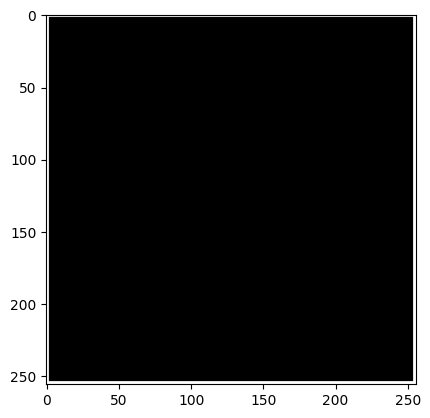

In [34]:
i = unwindowed[1][0]
# i = np.clip(i, -1024, 1000)
i = (i > -40) & (i < 120)
i = ndimage.binary_erosion(i, iterations=2)
i = ndimage.binary_fill_holes(i)
i = 1 - i
print(np.mean(i))
plt.imshow(i, cmap="gray")

More of these ideas a few cells below

In [35]:
volume_seq_2 = get_volume(paths[0], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-001...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-001...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Total time taken: 11.55 seconds
Average time taken per volume: 5.78 seconds
Done!


In [36]:
overlay_volume_sequence_interactive(volume_seq_2)

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

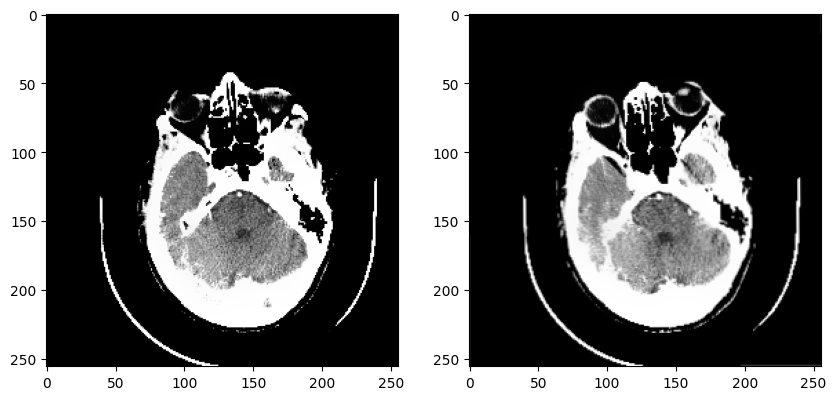

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(v1[0], cmap="gray")
ax[1].imshow(reg[0], cmap="gray")
plt.show()

In [38]:
volume_seq_2 = get_volume(paths[130], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-252...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-252...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Total time taken: 11.14 seconds
Average time taken per volume: 5.57 seconds
Done!


In [39]:
overlay_volume_sequence_interactive(volume_seq_2)

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

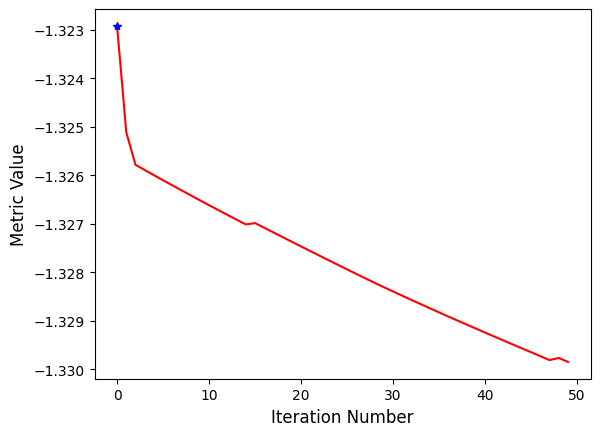

Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (500) exceeded.
-1.329919927048057
[1.]
avg_angle=-0.0012 avg_tx=0.0457 avg_ty=-0.0163 avg_cx=127.5000 avg_cy=127.5000
nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [40]:
reg = register_volume_inplane_weighted(volume_seq_2[0], volume_seq_2[1], n_samples=1, lr=1e-4, n_iters=500)
overlay_volume_sequence_interactive([volume_seq_2[0], reg])

## An registration framwork based on MSE
- optimized registration parameters
- added customizability

In [75]:
def register_2(moving_volume: np.ndarray, reference_volume: np.ndarray, n_samples: int = 5, 
               lr: float = 1.0, n_iters: int = 1000, relaxation_factor: float = 0.99, 
               gradient_magnitude_tolerance: float = 1e-5, max_step: float = 4.0, min_step: float = 5e-4, 
               weighting_scheme: str = 'inverse', spacing: tuple = (1, 1), plot_metrics: bool = True,
               multi_res: bool = False, smoothing_sigma: float = 2.0,
               verbose: bool = False):
    Y, Z, X = moving_volume.shape
    
    middle = Y // 2
    half_range = n_samples // 2
    # Sample slice indices evenly   
    slice_indices = np.linspace(middle - half_range, middle + half_range, n_samples, dtype=int)
    
    # Store transforms and their weights
    transforms = []
    metric_values = []

    def command_iteration(method):
        if (method.GetOptimizerIteration() + 1) % 50 == 0:
            print(f"Iteration: {method.GetOptimizerIteration()}")
            print(f"Metric value: {method.GetMetricValue():.4f}")

    # Register each sampled slice
    for slice_idx in slice_indices:
        print(f"Registering slice {slice_idx} of {Y}")
        # Get corresponding slices
        moving_slice = moving_volume[slice_idx]
        reference_slice = reference_volume[slice_idx]
        # Set min pixel value to 0 so that background aligns with pixels moved in by transformation during registration
        min_pixel_value = np.min(moving_slice)
        moving_slice, reference_slice = moving_slice - min_pixel_value, reference_slice - min_pixel_value
        if verbose:
            print(f"{min_pixel_value=}")
        # Convert to SimpleITK images
        moving_image = sitk.GetImageFromArray(moving_slice)
        reference_image = sitk.GetImageFromArray(reference_slice)
        if not multi_res:
            moving_image = sitk.DiscreteGaussian(moving_image, smoothing_sigma)
            reference_image = sitk.DiscreteGaussian(reference_image, smoothing_sigma)
        
        # Set 2D spacing
        moving_image.SetSpacing(spacing)
        reference_image.SetSpacing(spacing)
        
        # Initialize 2D transform
        initial_transform = sitk.CenteredTransformInitializer(
            moving_image,
            reference_image,
            sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        # Setup registration method
        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsMeanSquares()
        

        # Optimizer settings
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=lr,
            maximumStepSizeInPhysicalUnits=max_step,
            minStep=min_step,
            numberOfIterations=n_iters,
            gradientMagnitudeTolerance=gradient_magnitude_tolerance,
            relaxationFactor=relaxation_factor,
            
        )
        if multi_res:
            registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[2, 1])
            registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1, 2])
            registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        registration_method.SetInitialTransform(initial_transform)
        registration_method.SetInterpolator(sitk.sitkLinear)
        if plot_metrics:
            registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
            registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
            registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
            registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
            registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, 'MSE'))
        try:
            final_transform = registration_method.Execute(reference_image, moving_image)
            metric_value = registration_method.GetMetricValue()
            print(slice_idx)
            print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
            print(f"Metric value: {metric_value:.4f}")
            # Store transform parameters and weight
            params = final_transform.GetParameters()
            center = final_transform.GetCenter()
            transforms.append((params, center))
            metric_values.append(metric_value)
            
        except RuntimeError as e:
            print(f"Registration failed for slice {slice_idx}: {e}")
            continue
    
    if not transforms:
        print("No successful registrations - returning original volume")
        return moving_volume
    
    # Convert metric values to weights based on chosen scheme
    metric_values = np.array(metric_values)
    print(metric_values)

    if weighting_scheme == 'inverse':
        # Original inverse weighting
        weights = 1.0 / (metric_values + 1e-10)

    elif weighting_scheme == 'inverse_root':
        weights = 1.0 / (np.sqrt(metric_values) + 1e-10)
    
    elif weighting_scheme == 'exponential':
        # Exponential decay: w = exp(-metric_value)
        # More robust to outliers than inverse
        weights = np.exp(-metric_values)
    
    elif weighting_scheme == 'softmax':
        # Softmax-based weighting: emphasizes better matches while maintaining non-zero weights
        # Negative because lower metric values are better
        weights = np.exp(-metric_values) / np.sum(np.exp(-metric_values))
        
    elif weighting_scheme == 'rank':
        # Rank-based weighting: less sensitive to absolute metric values
        ranks = np.argsort(np.argsort(-metric_values))  # Higher rank for lower metric value
        weights = 1.0 / (ranks + 1)
    
    elif weighting_scheme == 'threshold':
        # Threshold-based: only keep transforms with metric values below mean
        mean_metric = np.mean(metric_values)
        weights = np.where(metric_values < mean_metric, 1.0, 0.0)
        if np.sum(weights) == 0:  # If all transforms are above mean
            weights = np.ones_like(metric_values)
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Compute weighted average transformation
    avg_angle = 0
    avg_tx = 0
    avg_ty = 0
    avg_cx = 0
    avg_cy = 0
    
    for (params, center), weight in zip(transforms, weights):
        avg_angle += params[0] * weight
        avg_tx += params[1] * weight
        avg_ty += params[2] * weight
        avg_cx += center[0] * weight
        avg_cy += center[1] * weight
    
    print(f"{avg_angle=:.4f} {avg_tx=:.4f} {avg_ty=:.4f} {avg_cx=:.4f} {avg_cy=:.4f}")
    # print(f"Time taken: {time() - t1}")
        # Create final average transform
    final_transform = sitk.Euler2DTransform()
    final_transform.SetAngle(avg_angle)
    final_transform.SetTranslation((avg_tx, avg_ty))
    final_transform.SetCenter((avg_cx, avg_cy))
    
    # Apply transform to each slice of moving volume
    registered_volume = np.zeros_like(moving_volume)
    for i in range(moving_volume.shape[0]):
        moving_slice = sitk.GetImageFromArray(moving_volume[i])
        registered_slice = sitk.Resample(
            moving_slice,
            reference_image,
            final_transform,
            sitk.sitkLinear,
            0.0, # min_pixel_value,
            moving_slice.GetPixelID()
        )
        registered_volume[i] = sitk.GetArrayFromImage(registered_slice) + min_pixel_value

    return registered_volume

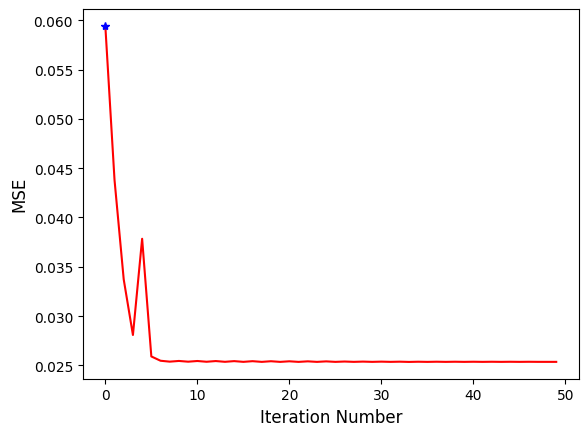

Iteration: 499
Metric value: 0.0564
8
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (500) exceeded.
Metric value: 0.0564
[0.05638926]
avg_angle=-0.0301 avg_tx=-2.2645 avg_ty=0.3219 avg_cx=127.5000 avg_cy=127.5000


In [76]:
reg_2 = register_2(v2, v1, n_samples=1, lr=1, n_iters=500, weighting_scheme='inverse', plot_metrics=True)

In [43]:
overlay_volume_sequence_interactive([v1, reg_2])

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [44]:
multi_vol_seq_interactive([v, [v1, reg_2]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [45]:
import os
dataset_path = os.path.expanduser('~/Desktop/UniToBrain')
path = os.path.join(dataset_path, 'MOL-112')


## Let's try registration with different data:
- less aggressive windowing
- Skull-stripping

In [46]:
v_raw = get_volume(paths[13], extract_brain=False, windowing=False, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]
Total time taken: 13.11 seconds
Average time taken per volume: 6.55 seconds
Done!


In [47]:
from preprocessing import get_3d_mask, apply_mask
# v_raw[0] = apply_mask(v_raw[0], get_3d_mask(v_raw[0]))
# v_raw[1] = apply_mask(v_raw[1], get_3d_mask(v_raw[1]))
# v_raw = np.clip(v_raw, -200, 80)
multi_vol_seq_interactive([v_raw, [v_raw[0], v_raw[1]]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

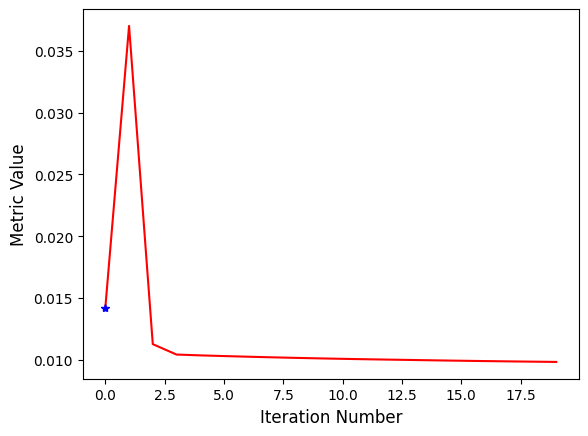

Iteration: 199
Metric value: 0.0098
8
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Metric value: 0.0098
[0.00981497]
avg_angle=-0.0006 avg_tx=-0.6857 avg_ty=0.0479 avg_cx=127.5000 avg_cy=127.5000


In [48]:
reg_raw = register_2(v_raw[1], v_raw[0], n_samples=1, lr=1, n_iters=200, relaxation_factor=0.8)

In [49]:
multi_vol_seq_interactive([v_raw, [v_raw[0], reg_raw]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [50]:
import os
dataset_path = os.path.expanduser('~/Desktop/UniToBrain')
path = os.path.join(dataset_path, 'MOL-133')
v_133 = get_volume(path, extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-133...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-133...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Total time taken: 11.58 seconds
Average time taken per volume: 5.79 seconds
Done!


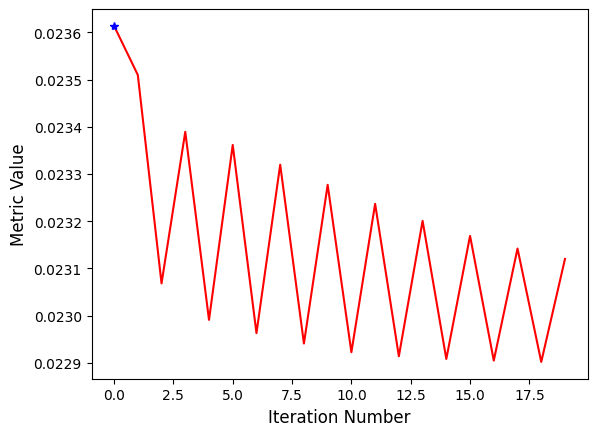

Iteration: 199
Metric value: 0.2603
8
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Metric value: 0.2603
[0.26030067]
avg_angle=0.0043 avg_tx=0.1277 avg_ty=0.2678 avg_cx=127.5000 avg_cy=127.5000


In [51]:
reg_133 = register_2(v_133[1], v_133[0], n_samples=1, lr=1, n_iters=200, weighting_scheme='inverse')

In [52]:
multi_vol_seq_interactive([v_133, [v_133[0], reg_133]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

This works! Notice the rotation correction from t=0 to t=1

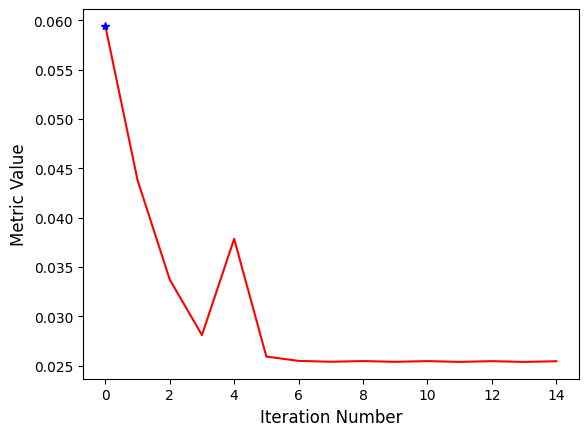

Iteration: 149
Metric value: 0.3390
8
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (150) exceeded.
Metric value: 0.3390
[0.33895683]
avg_angle=-0.0299 avg_tx=-2.2621 avg_ty=0.3250 avg_cx=127.5000 avg_cy=127.5000


interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [53]:
# Let's try this on the previous scan
v_100_reg2 = register_2(v[1], v[0], n_samples=1, lr=1, n_iters=150, weighting_scheme='inverse')
multi_vol_seq_interactive([v, [v[0], v_100_reg2]])

My goodness this works too, I've spent wayyy to much time on this simple registration task

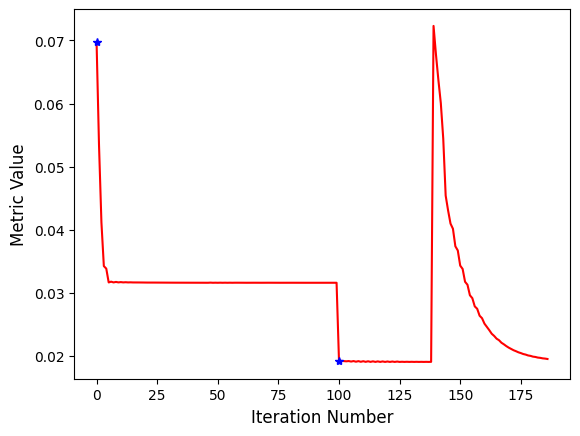

8
Stopping condition: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 869 iterations. Gradient magnitude (2.43366e-06) is less than gradient magnitude tolerance (1e-05).
Metric value: 0.0190
[0.01901962]
avg_angle=-0.0298 avg_tx=-2.3617 avg_ty=0.3198 avg_cx=127.5000 avg_cy=127.5000


interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [54]:
v_100_reg_multi_res = register_2(v[1], v[0], n_samples=1, lr=1, n_iters=1000, weighting_scheme='inverse', multi_res=True)
multi_vol_seq_interactive([v, [v[0], v_100_reg_multi_res]])

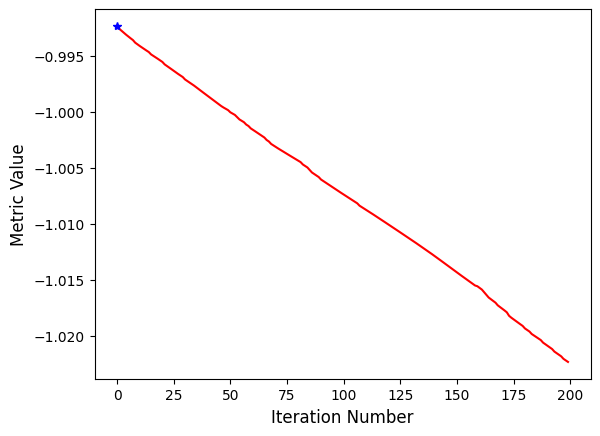

Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (2000) exceeded.
-1.0224447093862696
[1.]
avg_angle=-0.0070 avg_tx=-0.4709 avg_ty=0.0982 avg_cx=127.5000 avg_cy=127.5000


In [55]:
v_100_reg1 = register_volume_inplane_weighted(v[1], v[0], n_samples=1, lr=1e-3, n_iters=2000)

In [61]:
v_106 = get_volume(os.path.join(dataset_path, 'MOL-106'), extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-106...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-106...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Total time taken: 11.00 seconds
Average time taken per volume: 5.50 seconds
Done!


In [64]:
overlay_volume_sequence_interactive(v_106)

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

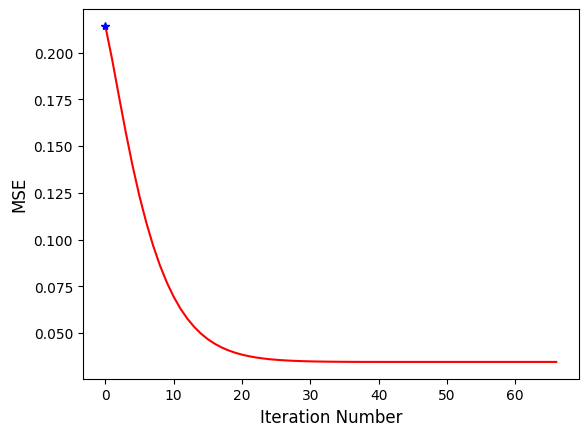

8
Stopping condition: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 668 iterations. Gradient magnitude (7.81922e-06) is less than gradient magnitude tolerance (1e-05).
Metric value: 0.0346
[0.03457331]
avg_angle=0.0556 avg_tx=7.2388 avg_ty=3.0815 avg_cx=127.5000 avg_cy=127.5000
nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [77]:
reg_106 = register_2(v_106[1], v_106[0], n_samples=1, lr=1.2, n_iters=1000, weighting_scheme='inverse', smoothing_sigma=5, )
overlay_volume_sequence_interactive([v_106[0], reg_106])

In [73]:
reg_106_2 = reg_106 + np.min(v_106[0]) - np.min(reg_106)
np.min(reg_106_2), np.min(v_106[0])
# overlay_volume_sequence_interactive([v_106[0], reg_106_2])

(-0.6373466, -0.63734657)

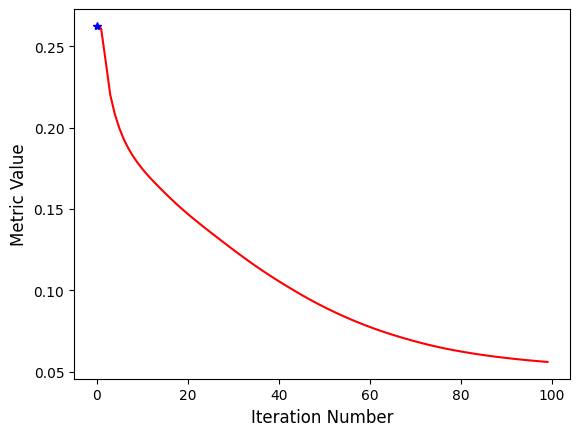

Iteration: 999
Metric value: 0.0559
8
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (1000) exceeded.
Metric value: 0.0559
[0.05586808]
avg_angle=-0.0528 avg_tx=-6.5830 avg_ty=-2.1816 avg_cx=127.5000 avg_cy=127.5000


interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [58]:
reg_106 = register_2(v_106[0], v_106[1], n_samples=1, lr=0.11, n_iters=1000, weighting_scheme='inverse')
multi_vol_seq_interactive([v_106, [reg_106, v_106[1]]])

Learning rate too low

# Without Windowing

In [59]:
v_106_no_window = get_volume(os.path.join(dataset_path, 'MOL-106'), extract_brain=False, windowing=False, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)
v_106_no_window = np.clip(v_106_no_window, -1024, 3000)

Loading /Users/simonma/Desktop/UniToBrain/MOL-106...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-106...
5 [0.488281, 0.488281]
Total time taken: 12.64 seconds
Average time taken per volume: 6.32 seconds
Done!


In [60]:
overlay_volume_sequence_interactive(volum)

NameError: name 'volum' is not defined

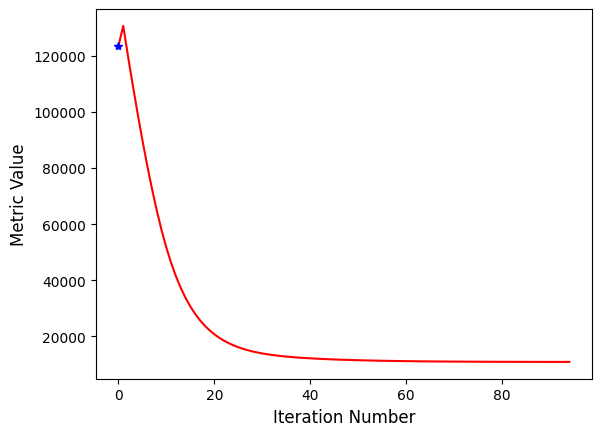

8
Stopping condition: RegularStepGradientDescentOptimizerv4: Step too small after 947 iterations. Current step (0.000496412) is less than minimum step (0.0005).
Metric value: 10934.7312
[10934.73124761]
avg_angle=0.0526 avg_tx=7.1712 avg_ty=2.8749 avg_cx=127.5000 avg_cy=127.5000


In [333]:
reg_106_no_window = register_2(v_106_no_window[1], v_106_no_window[0], n_samples=1, lr=1, n_iters=1000)


In [334]:
multi_vol_seq_interactive([v_106_no_window, [v_106_no_window[0],reg_106_no_window]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

# Noise Estimation
- This part should help select a volume to act as the reference for registering other volumes in the sequence. It should be the least corrupted and least noisy out of the first few volumes of the sequence.
- As we are doing in-plane registration, is suffices to only look at the images which are being sampled in registration and do noise estimation in 2D.

In [312]:
import numpy as np
from scipy import ndimage
from sklearn.linear_model import LinearRegression

def get_local_statistics(img, patch_size):
    # Calculate local means and variances using sliding windows
    kernel = np.ones((patch_size, patch_size)) / (patch_size * patch_size)
    local_mean = ndimage.convolve(img, kernel, mode='reflect')
    local_var = ndimage.convolve(img**2, kernel, mode='reflect') - local_mean**2
    return local_mean, local_var

def estimate_noise_levels(image, patch_size=16):
    """
    Estimate quantum and electronic noise levels in a CT image.
    
    Parameters:
    -----------
    image : ndarray
        2D array representing the CT image
    patch_size : int
        Size of patches for local variance estimation
    
    Returns:
    --------
    quantum_noise : float
        Estimated quantum noise level
    electronic_noise : float
        Estimated electronic noise level
    """
    
    # Get local means and variances
    means, variances = get_local_statistics(image, patch_size)
    
    # Flatten arrays for regression
    means = means.flatten()
    variances = variances.flatten()
    
    # Remove outliers and negative values
    valid_indices = (variances > 0) & (means > 0)
    means = means[valid_indices]
    variances = variances[valid_indices]
    
    # Prepare data for linear regression
    X = means.reshape(-1, 1)
    y = variances
    
    # Fit linear model: variance = quantum_noise * mean + electronic_noise
    model = LinearRegression()
    model.fit(X, y)
    
    quantum_noise = model.coef_[0]  # Slope represents quantum noise
    electronic_noise = model.intercept_  # Y-intercept represents electronic noise
    
    return quantum_noise, electronic_noise

def validate_noise_estimation(image, patch_size=16, num_splits=5):
    """
    Validate noise estimation by comparing results across image subsets.
    
    Parameters:
    -----------
    image : ndarray
        2D array representing the CT image
    patch_size : int
        Size of patches for local variance estimation
    num_splits : int
        Number of random subsets to use for validation
    
    Returns:
    --------
    dict
        Dictionary containing mean and std of noise estimates
    """
    quantum_estimates = []
    electronic_estimates = []
    
    height, width = image.shape
    for _ in range(num_splits):
        # Create random mask for subset selection
        mask = np.random.rand(height, width) > 0.5
        subset = image.copy()
        subset[~mask] = 0
        
        # Estimate noise for subset
        q_noise, e_noise = estimate_noise_levels(subset, patch_size)
        quantum_estimates.append(q_noise)
        electronic_estimates.append(e_noise)
    
    return {
        'quantum_noise_mean': np.mean(quantum_estimates),
        'quantum_noise_std': np.std(quantum_estimates),
        'electronic_noise_mean': np.mean(electronic_estimates),
        'electronic_noise_std': np.std(electronic_estimates)
    }

def plot_noise_analysis(image, quantum_noise, electronic_noise):
    """
    Create visualization of noise estimation results.
    
    Parameters:
    -----------
    image : ndarray
        2D array representing the CT image
    quantum_noise : float
        Estimated quantum noise level
    electronic_noise : float
        Estimated electronic noise level
    """
    import matplotlib.pyplot as plt
    
    # Calculate local means and variances
    means, variances = get_local_statistics(image, 16)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(means.flatten(), variances.flatten(), alpha=0.1, label='Local measurements')
    
    # Plot fitted line
    x_range = np.linspace(means.min(), means.max(), 100)
    y_fit = quantum_noise * x_range + electronic_noise
    plt.plot(x_range, y_fit, 'r-', label='Fitted noise model')
    
    plt.xlabel('Local mean intensity')
    plt.ylabel('Local variance')
    plt.title('Noise Analysis Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

(-3.9212627, 454.2466)


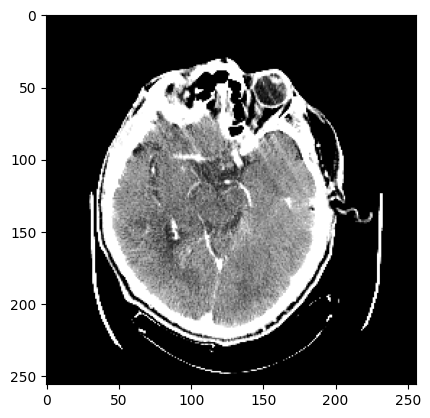

In [326]:
print(estimate_noise_levels(v_106[0][0], patch_size=3))
plt.imshow(v_106[0][0], cmap='gray')

NameError: name 'v_106' is not defined

In [324]:
from preprocessing import bilateral_filter
filtered = bilateral_filter(v_106[0][0], 10, 10)
estimate_noise_levels(filtered, patch_size=3)

(1.6000807559922925, 106.26096776579541)

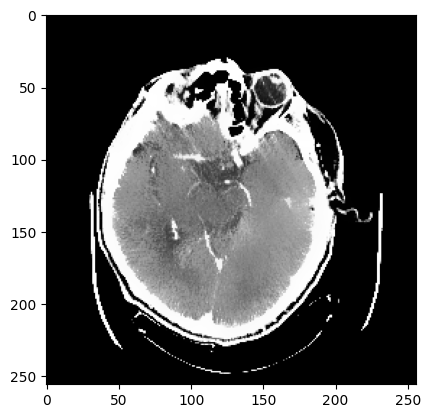

In [323]:
plt.imshow(filtered, cmap='gray')

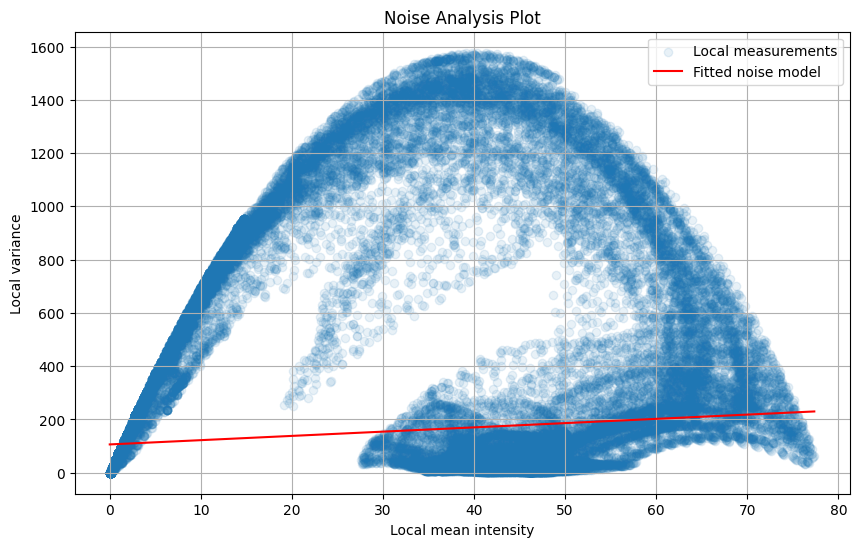

In [327]:
plot_noise_analysis(filtered, *estimate_noise_levels(filtered, patch_size=3))